# SocraticFlanT5 - Baseline

## Introduction

The goal of this jupyter notebook is to reproduce the Socratic Models paper with the FlanT5 model.
Here we simply reimplement the pipeline used by A. Zeng et al. as closely as possible.
This provides a baseline for us to build upon.

## Imports

In [8]:
# Package loading
# import os
# import requests
# import clip
# import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
# from profanity_filter import ProfanityFilter
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, set_seed
# from utils import print_time_dec

# Local imports
from image_captioning import ClipManager, ImageManager, VocabManager, FlanT5Manager, print_clip_info

# autoreload modules when code is changed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set seed & device

In [2]:
set_seed(42)    # Set seed for reproducibility
# Set the device to use
if getattr(torch, 'has_mps', False):
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f'Using device: {device}')

### Class instantiation

In [18]:
# Instantiate the clip manager
clip_manager = ClipManager(device=device)

# Instantiate the image manager
image_manager = ImageManager(download_samples=True)

# Instantiate the vocab manager
vocab_manager = VocabManager()

# Instantiate the Flan T5 manager
flan_manager = FlanT5Manager(version='google/flan-t5-xxl', use_api=True, device=device)

# Print out clip model info
# print_clip_info(clip_manager.model)

load_places starting!
load_places took 0.0s!
load_objects starting!
load_objects took 0.0s!
Model parameters (total): 427616513
Model parameters (image encoder): 303966208
Model parameters (text encoder): 122999808
Input image resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
# Set the image path
img_dir = 'data/sample_images'
fname = 'astronaut_with_beer.jpg'
img_path = f'{img_dir}/{fname}'

### Create text embeddings

In [20]:
# Calculate the place features
place_feats = clip_manager.get_text_feats([f'Photo of a {p}.' for p in vocab_manager.place_list])

# Calculate the object features
object_feats = clip_manager.get_text_feats([f'Photo of a {o}.' for o in vocab_manager.object_list])

get_text_feats starting!
get_text_feats took 2.2s!
get_text_feats starting!
get_text_feats took 14.5s!


### Load image and compute image embedding

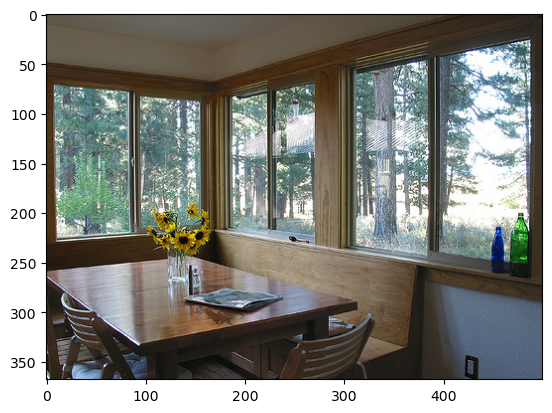

In [21]:
# Load image.
img = image_manager.load_image(img_path)
# Get image representation
img_feats = clip_manager.get_img_feats(img)
# Show the image
plt.imshow(img)
plt.show()

## Zero shot VLM - Image type classification

In [22]:
# Zero-shot VLM: classify image type.
img_types = ['photo', 'cartoon', 'sketch', 'painting']
img_types_feats = clip_manager.get_text_feats([f'This is a {t}.' for t in img_types])
sorted_img_types, img_type_scores = clip_manager.get_nn_text(img_types, img_types_feats, img_feats)
img_type = sorted_img_types[0]
print(f'This is a {img_type}.')

get_text_feats starting!
get_text_feats took 0.0s!
This is a photo.


## Zero shot VLM - Number of people classification

In [23]:
# Zero-shot VLM: classify number of people.
ppl_texts = ['no people', 'people']
ppl_feats = clip_manager.get_text_feats([f'There are {p} in this photo.' for p in ppl_texts])
sorted_ppl_texts, ppl_scores = clip_manager.get_nn_text(ppl_texts, ppl_feats, img_feats)
ppl_result = sorted_ppl_texts[0]
if ppl_result == 'people':
    ppl_texts = ['is one person', 'are two people', 'are three people', 'are several people', 'are many people']
    ppl_feats = clip_manager.get_text_feats([f'There {p} in this photo.' for p in ppl_texts])
    sorted_ppl_texts, ppl_scores = clip_manager.get_nn_text(ppl_texts, ppl_feats, img_feats)
    ppl_result = sorted_ppl_texts[0]
else:
    ppl_result = f'are {ppl_result}'

print(f'There {ppl_result} in this photo.')

get_text_feats starting!
get_text_feats took 0.0s!
There are no people in this photo.


## Zero shot VLM - Image place classification

In [24]:
# Zero-shot VLM: classify places.
place_topk = 3
sorted_places, places_scores = clip_manager.get_nn_text(vocab_manager.place_list, place_feats, img_feats)
print(f'Location: {sorted_places[0]}')

Location: indoor bow window


## Zero shot VLM - Image object classification

In [25]:
# Zero-shot VLM: classify objects.
obj_topk = 10
sorted_obj_texts, obj_scores = clip_manager.get_nn_text(vocab_manager.object_list, object_feats, img_feats)
object_list = ''
for i in range(obj_topk):
    object_list += f'{sorted_obj_texts[i]}, '
object_list = object_list[:-2]
print(f'Top 10 objects recognized: \n{sorted_obj_texts[:10]}')

Top 10 objects recognized: 
['double-hung window', 'casement window', 'sliding window', 'pivoting window', 'breakfast area, breakfast nook', 'dining area', 'storm window, storm sash', 'dining room, dining-room', 'bay window, bow window', 'lancet window']


## Zero shot LM - Caption generation

In [26]:
# Zero-shot LM: generate captions.
num_captions = 10
prompt = f'''I am an intelligent image captioning bot.
This image is a {img_type}. There {ppl_result}.
I think this photo was taken at a {sorted_places[0]}, {sorted_places[1]}, or {sorted_places[2]}.
I think there might be a {object_list} in this {img_type}.
A creative short caption I can generate to describe this image is:'''

model_params = {'temperature': 0.9, 'max_length': 40, 'do_sample': True}
caption_texts = flan_manager.generate_response(num_captions * [prompt], model_params)

print(f'LM caption created: \n{caption_texts}')

LM caption created: 
['Three double-hung windows in dining room', 'With the folding glass doors open, the breakfast area and dining room gain much-needed, fresh air', 'An arched breakfast nook has wooden paneling along the top, with windows that are partially open', 'basic kitchen with nintendo switch and cobalt blue curtains.', 'A breakfast nook type area, with and a storm window inside in a dining space with', 'Bay window with a breakfast area and fireplace', 'A bathroom with sink, tub, and window', 'bow window sealed with storm window in the dining area', 'Double-hung windows.', "red and white's observe into breakfast nook with a bay window and a brick wall"]


## Zero shot VLM - Caption ranking

In [27]:
# Zero-shot VLM: rank captions.
caption_feats = clip_manager.get_text_feats(caption_texts)
sorted_captions, caption_scores = clip_manager.get_nn_text(caption_texts, caption_feats, img_feats)
print(f'{sorted_captions[0]}\n')

get_text_feats starting!
get_text_feats took 0.0s!
Three double-hung windows in dining room



## Summary

In [28]:
print(f'VLM: This image is a:')
for img_type, score in zip(sorted_img_types, img_type_scores):
    print(f'{score:.4f} {img_type}')

print(f'\nVLM: There:')
for ppl_text, score in zip(sorted_ppl_texts, ppl_scores):
    print(f'{score:.4f} {ppl_text}')

print(f'\nVLM: I think this photo was taken at a:')
for place, score in zip(sorted_places[:place_topk], places_scores[:place_topk]):
    print(f'{score:.4f} {place}')

print(f'\nVLM: I think there might be a:')
for obj_text, score in zip(sorted_obj_texts[:obj_topk], obj_scores[:obj_topk]):
    print(f'{score:.4f} {obj_text}')

print(f'\nLM generated captions ranked by VLM scores:')
for caption, score in zip(sorted_captions, caption_scores):
    print(f'{score:.4f} {caption}')

VLM: This image is a:
0.1444 photo
0.1246 sketch
0.1011 painting
0.0878 cartoon

VLM: There:
0.1375 no people
0.1346 people

VLM: I think this photo was taken at a:
0.2505 indoor bow window
0.2403 dining room
0.2377 interior balcony

VLM: I think there might be a:
0.2837 double-hung window
0.2803 casement window
0.2605 sliding window
0.2553 pivoting window
0.2481 breakfast area, breakfast nook
0.2474 dining area
0.2458 storm window, storm sash
0.2449 dining room, dining-room
0.2426 bay window, bow window
0.2423 lancet window

LM generated captions ranked by VLM scores:
0.2856 Three double-hung windows in dining room
0.2795 Double-hung windows.
0.2782 A breakfast nook type area, with and a storm window inside in a dining space with
0.2764 An arched breakfast nook has wooden paneling along the top, with windows that are partially open
0.2740 bow window sealed with storm window in the dining area
0.2516 Bay window with a breakfast area and fireplace
0.2325 With the folding glass doors ope